<a href="https://colab.research.google.com/github/nv-hiep/nguyen_et_al_2019/blob/main/SPONGE_data_and_the_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. LSTMs and CNNs can be very slow without a GPU.')
    if IS_COLAB:
        print('Go to Runtime > Change runtime and select a GPU hardware accelerator.')

# Common imports
import os
import shutil
import itertools
import glob
import numpy as np
import matplotlib.image as mpimg
import pandas as pd

import string
import pickle

from tqdm import tqdm
from time import time
from PIL import Image


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

In [2]:
from scipy.io import readsav
from astropy.io import fits

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# !pip install latex
# ! apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng

# 2. Connect to Google Drive

In [4]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Sun Jul  4 09:30:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [6]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019/
!ls

/content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019
fitted_parameters			  images
Haslam					  Plot_Gaussian_and_pseudo_Voigt.ipynb
HI_decomposition_nguyen_et_al_2019.ipynb  scripts
HI_spectra				  Source_list.csv
HT03_data_and_the_fit.ipynb		  SPONGE
HT03_MS					  SPONGE_data_and_the_fit.ipynb


In [7]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019


## 3. Paths to Data Directories

In [18]:
PROJECT_PATH       = '/content/gdrive/My Drive/Colab Notebooks/nguyen_et_al_2019'
SPECTRA_PATH       = os.path.join( PROJECT_PATH, 'HI_spectra' )
FITTED_PARAMS_PATH = os.path.join( PROJECT_PATH, 'fitted_parameters' )
HT03_PATH          = os.path.join( PROJECT_PATH, 'HT03_MS' )
HASLAM_PATH        = os.path.join( PROJECT_PATH, 'Haslam' )
SPONGE_PATH        = os.path.join( PROJECT_PATH, 'SPONGE' )

CNM_params  = os.path.join( FITTED_PARAMS_PATH, 'CNM_fitted_parameters', 'CNM_Gaussian_parameters.fits' )
WNM_params  = os.path.join( FITTED_PARAMS_PATH, 'WNM_fitted_parameters', 'WNM_Gaussian_parameters.fits' )

psV_CNM_params  = os.path.join( FITTED_PARAMS_PATH, 'CNM_fitted_parameters', 'CNM_pseudoVoigt_parameters.fits' )
psV_WNM_params  = os.path.join( FITTED_PARAMS_PATH, 'WNM_fitted_parameters', 'WNM_pseudoVoigt_parameters.fits' )

HT03_HI_SPECTRA = os.path.join( HT03_PATH, 'MS_HI_spectra.npy' )
HT03_FIT_PARAMS = os.path.join( HT03_PATH, 'MS_gfit_params_dict.npy' )
TB_408_SAV      = os.path.join( HASLAM_PATH, 'tb_408.sav' )
HT03_PLOTS      = os.path.join( HT03_PATH, 'plots' )


SPONGE_DATA     = os.path.join( SPONGE_PATH, 'data' )
SPONGE_PLOTS    = os.path.join( SPONGE_PATH, 'plots' )
SPONGE_PARAMS   = os.path.join( SPONGE_PATH, 'params' )

# 4. Read and plot SPONGE data

In [10]:
datafile     = os.path.join( SPONGE_DATA, '3C138.fits' )
data, header = fits.getdata(datafile, header=True)


print(header)
for  x in header:
	print(x, header[x])


XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   48 / length of dimension 1                          NAXIS2  =                 1491 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    6 / number of table fields                         TTYPE1  = 'v_tau   '                                                            TFORM1  = 'D       '                                                            TUNIT1  = 'KM/S    '                                                            TTYPE2  = 'tau     '                                                            TFORM2  = 'D       '                    

In [11]:
src    = header['NAME']
tau    = data['tau']
v_tau  = data['v_tau']
sigtau = data['sigma_tau']
tb     = data['Tb']
v_tb   = data['v_tb']
sigtb  = data['sigma_Tb']
emt    = np.exp(-tau)
sigemt = np.abs( np.exp(-tau)*sigtau )
xli    = header['GLON']
xbi    = header['GLAT']

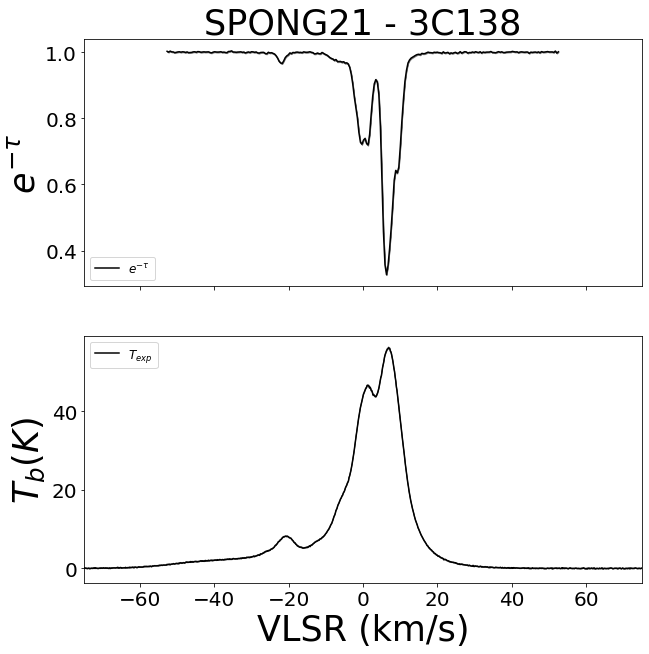

In [14]:
## Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), sharex=True)

## Absorption
ax1.plot(v_tau, emt, 'k-', label=r'$e^{-\tau}$')
ax1.fill_between(v_tau, emt-sigemt, emt+sigemt, color='gray', label=r'')

ax1.set_title('SPONG21 - ' + src, fontsize = 35)
ax1.set_ylabel(r'$e^{-\tau}$', fontsize = 35)
# ax1.set_xlabel('VLSR (km/s)', fontsize = 35)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(-75., 75.)
ax1.legend(loc='lower left', fontsize=12)

## Emission
ax2.plot(v_tb, tb, 'k-', label=r'$T_{exp}$')
ax2.fill_between(v_tb, tb-sigtb, tb+sigtb, color='gray', label=r'')


ax2.set_ylabel('$T_{b} (K)$', fontsize = 35)
ax2.set_xlabel('VLSR (km/s)', fontsize = 35)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(-75., 75.)
ax2.legend(loc='upper left', fontsize=12)

# plt.savefig(src + '.png', bbox_inches='tight', pad_inches=0.09, format='png', dpi=150)

plt.show()
plt.close(fig)

# 5. SPONGE: Plot CNM and WNM components

In [15]:
## Multiple (N) Gaussians + offset. ##
 #
 # params list  v    VLSR
 # params float zr   estimated constant zero offset of the data points.
 # params list  h    the array of N estimated heights of the Gaussians.
 # params list  v0   the array of N estimated centers of the Gaussians.
 # params list  w    the array of N estimated halfwidths of the Gaussians.
 #
 # return 1-D-array  tf  The calculated points.
 #
 # version 01/2017
 # author Nguyen Van Hiep ##
def gfunc(v, zr, h, v0, w):
  dp600 = np.float64(0.60056120)

  if(np.isscalar(v)):
    v  = np.array([v], dtype='float64')

  if(np.isscalar(h)):
    h  = np.array([h], dtype='float64')

  if(np.isscalar(v0)):
    v0 = np.array([v0], dtype='float64')

  if(np.isscalar(w)):
    w  = np.array([w], dtype='float64')

  #DETERMINE NR OF GAUSSIANS...
  ng = len(h)

  ret = 0.*v + zr
  for i in range(ng):
    if (w[i] > 0.):
      ret = ret + h[i]*np.exp(- ( (v-v0[i])/(dp600*w[i]))**2)

  return ret

In [74]:
src = '3C138'

datafile     = os.path.join( SPONGE_DATA, src + '.fits' )
data, header = fits.getdata(datafile, header=True)

src    = header['NAME']
tau    = data['tau']
v_tau  = data['v_tau']
sigtau = data['sigma_tau']
tb     = data['Tb']
v_tb   = data['v_tb']
sigtb  = data['sigma_Tb']
emt    = np.exp(-tau)
sigemt = np.abs( np.exp(-tau)*sigtau )
xli    = header['GLON']
xbi    = header['GLAT']

In [75]:
## Read fit params of HI components from SPONG21 ##
data, header = fits.getdata(os.path.join(SPONGE_PARAMS, 'SPONGE_DR1_absparams.fits'), header=True)
cencsp1  = data['VCEN']
hgtcsp1  = data['TAU0']
widcsp1  = data['FWHM0']
namecsp1 = data['NAMES']
tssp1    = data['ts']
namecsp1 = list( map(str.rstrip, namecsp1) )
print(namecsp1)


print()
data, header = fits.getdata(os.path.join(SPONGE_PARAMS, 'SPONGE_DR1_emparams.fits'), header=True)
cenwsp1  = data['VCEN']
hgtwsp1  = data['TB0']
widwsp1  = data['FWHM0']
namewsp1 = data['NAMES']
namewsp1 = list( map(str.rstrip, namewsp1) )
print(namewsp1)

['3C273', '3C273', '3C273', '3C138', '3C138', '3C138', '3C138', '3C138', '3C138', '3C154', '3C154', '3C154', '3C154', '3C154', '3C154', '4C04.51', '4C04.51', '3C459', '3C459', '3C459', '3C459', '3C459', '3C459', '3C459', '3C225B', '3C225B', '3C225B', '3C225B', '3C225B', 'PKS0531', 'PKS0531', 'PKS0531', 'PKS0531', 'PKS0531', 'PKS0531', 'PKS0531', '3C147', '3C147', '3C147', '3C147', '3C147', '3C147', '3C123', '3C123', '3C123', '3C123', '3C123', '3C123', '4C33.48', '4C33.48', '4C33.48', '4C33.48', '4C33.48', '3C433', '3C433', '3C433', '3C433', '3C433', '3C327.1', '3C327.1', '3C327.1', '3C327.1', '3C327.1', '3C298', '3C298', '3C133', '3C133', '3C133', '3C133', '3C133', '3C133', '3C133', '3C133', '3C133', '4C16.09', '4C16.09', '4C16.09', '4C16.09', '4C16.09', '4C16.09', '3C78', '3C78', '3C78', '3C78', '3C78', '3C225A', '3C225A', '3C225A', '3C225A', '3C225A', '3C225A', '3C454.3', '3C454.3', '3C454.3', '3C454.3', '3C454.3', '3C454.3', '3C454.3', '3C454.3', '4C32.44', '4C32.44', '3C120', '3C12

In [76]:
namecsp1 = np.array( namecsp1 )
namewsp1 = np.array( namewsp1 )

In [77]:
idnx  = np.where( namecsp1 == src )[0]
cenc  = cencsp1[idnx]
hgtc  = hgtcsp1[idnx]
widc  = widcsp1[idnx]
namec = namecsp1[idnx]
ts    = tssp1[idnx]

idnx  = np.where( namewsp1 == src )[0]
cenw  = cenwsp1[idnx]
hgtw  = hgtwsp1[idnx]
widw  = widwsp1[idnx]
namew = namewsp1[idnx]

print('CNM: ', namec)
print('WNM:', namew)

CNM:  ['3C138' '3C138' '3C138' '3C138' '3C138' '3C138']
WNM: ['3C138' '3C138' '3C138']


In [78]:
print('sp1 - CNM, cencnm, hgtcnm, widcnm, Tspin: ' + str(len(hgtc)) + ' components')
for ci,hi,wi, tsi in zip(cenc, hgtc, widc, ts):
  ci = round(ci,2)
  hi = round(hi,2)
  wi = round(wi,2)
  tsi = round(tsi,2)
  print('CNM', src, ci, hi, wi, tsi)

print('sp1 - WNM, cenwnm, hgtwnm, widwnm: ' + str(len(hgtw)) + ' components')
for ci,hi,wi in zip(cenw, hgtw, widw):
  ci = round(ci,2)
  hi = round(hi,2)
  wi = round(wi,2)
  print('WNM', src, ci, hi, wi)

sp1 - CNM, cencnm, hgtcnm, widcnm, Tspin: 6 components
CNM 3C138 -21.95 0.03 2.28 133.52
CNM 3C138 -0.49 0.26 3.01 77.57
CNM 3C138 1.57 0.18 1.77 76.18
CNM 3C138 6.37 1.06 2.29 57.67
CNM 3C138 9.08 0.41 2.8 64.47
CNM 3C138 1.86 0.06 15.13 456.25
sp1 - WNM, cenwnm, hgtwnm, widwnm: 3 components
WNM 3C138 -9.22 6.87 46.04
WNM 3C138 -47.8 0.81 14.3
WNM 3C138 5.84 27.55 12.26


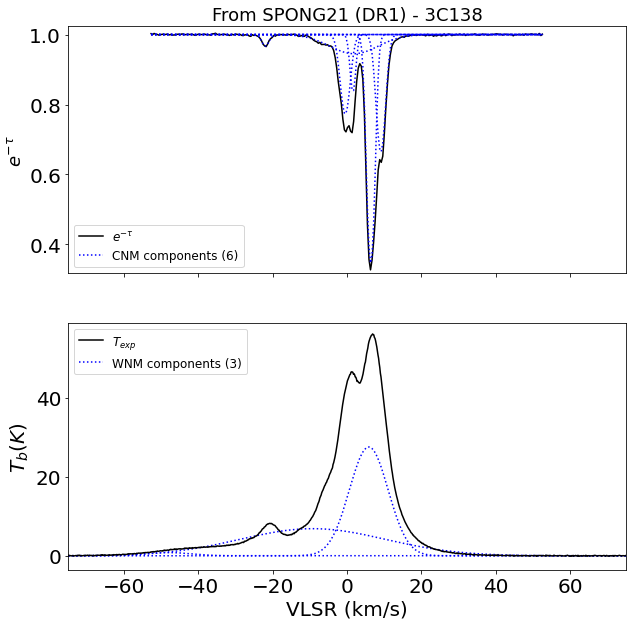

In [80]:
## Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), sharex=True)


## Absorption
ax = ax1
ax.plot(v_tau, emt, color='k', ls='-', label=r'$e^{-\tau}$')
# ax.plot(xfitcnm, fitcnm, 'r-', label='$Total\ fit$', lw=2)

for ceni,hgti,widi,tsi in zip(cenc, hgtc, widc, ts):
  ax.plot( v_tau, np.exp(-gfunc(v_tau, 0., [hgti], [ceni], [widi]) ), 'b:', label='')

ax.plot([0.], [0.], color='b', ls=':', zorder=-1, label=r'CNM components (' + str(len(hgtc)) + ')' )

ax.set_title('From SPONG21 (DR1) - ' + src, fontsize = 18)
ax.set_ylabel(r'$e^{-\tau}$', fontsize = 18)
# ax.set_xlabel('VLSR (km/s)', fontsize = 18)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# ax.set_xlim(-39., 33.)
ax.set_xlim(-75., 75.)
ax.set_ylim(0.97*np.min(emt[:255]), 1.02*np.max(emt[:255]))
ax.legend(loc='lower left', fontsize=12)

## Emission
ax = ax2
ax.plot(v_tb, tb, color='k', ls='-', label=r'$T_{exp}$')
# ax.plot(xdataem, tb_tot_fit, 'r-', label=r'$Total\ fit$')
# ax.plot(xdataem, tb_wnm_tot, color='violet', ls='-', zorder=-1, label=r'$Total\ WNM\ fit$')
# ax.plot(xdataem, tb_cnm_tot, color='b', ls='-', zorder=-1, label=r'$Total\ CNM\ fit$')
# ax[0].fill_between(xdataem, te-sigtexp, te+sigtexp, color='gray', label=r'')

for wcen, whgt, wwid in zip(cenw, hgtw, widw):
  ax.plot( v_tb, gfunc(v_tb, 0., [whgt], [wcen], [wwid]), 'b:', zorder=-1, label='')

ax.plot([0.], [0.], color='b', ls=':', zorder=-1, label=r'WNM components (' + str(len(hgtw)) + ')' )

ax.set_ylabel('$T_{b} (K)$', fontsize = 20)
ax.set_xlabel('VLSR (km/s)', fontsize = 20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# ax.set_xlim(-39., 33.)
ax.set_xlim(-75., 75.)
ax.legend(loc='upper left', fontsize=12)

# plt.savefig(src + '.png', bbox_inches='tight', pad_inches=0.09, format='png', dpi=150)

plt.show()
plt.close(fig)